__Objective__: Exploring characteristics of ad hominem users in CreateDebate

__Runtime__: CPU

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!git clone https://github.com/utkarsh512/CreateDebateScraper.git

Cloning into 'CreateDebateScraper'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 176 (delta 5), reused 4 (delta 4), pack-reused 170
Receiving objects: 100% (176/176), 207.95 KiB | 6.30 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [3]:
%cd CreateDebateScraper/src/nested/

/content/CreateDebateScraper/src/nested


In [4]:
from thread import Thread, Comment # from CreateDebateScraper
import pickle
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import json
from copy import deepcopy
import networkx as nx

# Loading CreateDebate debate dataset

In [5]:
comments = dict()

# topical forums on CreateDebate
categories = ['business', 'comedy', 'entertainment', 'health', 'law', 'nsfw',
              'politics2', 'religion', 'science', 'shopping', 'sports',
              'technology', 'travel', 'world']

# topical forums we're interested in!
categories_selected = ['politics2', 'religion', 'world', 'science', 'law', 'technology']
categories_labels = ['politics', 'religion', 'world', 'science', 'law', 'technology']

for x in categories:
    comments[x] = list()

In [6]:
# loading dataset from drive for interesting topical forums
for cat in tqdm(categories_selected):
    fp = open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/threads.log', 'rb')
    threads = list()
    try:
        while True:
            e = pickle.load(fp)
            threads.append(e)
    except EOFError:
        fp.close()
    print(f'{cat} - {len(threads)}')
    authors = dict()
    for thread in threads:
        for k, v in thread.comments.items():
            try:
                authors[v.author].append(v)
            except:
                authors[v.author] = list()
                authors[v.author].append(v)
    ctr = 0
    with open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/comments_with_score.log', 'rb') as fp:
        cws = pickle.load(fp)
    for author in authors.keys():
        for i in range(len(authors[author])):
            comment = authors[author][i]
            foo = deepcopy(comment.__dict__)
            foo['tag'] = cat
            foo['score'] = cws[ctr][0]
            foo['validation'] = cws[ctr][1][0]
            comments[cat].append(foo)
            ctr += 1

  0%|          | 0/6 [00:00<?, ?it/s]

politics2 - 10434


 17%|█▋        | 1/6 [00:04<00:23,  4.67s/it]

religion - 2841


 33%|███▎      | 2/6 [00:07<00:15,  3.84s/it]

world - 2008


 50%|█████     | 3/6 [00:09<00:08,  2.83s/it]

science - 1276


 67%|██████▋   | 4/6 [00:10<00:04,  2.18s/it]

law - 759


 83%|████████▎ | 5/6 [00:11<00:01,  1.76s/it]

technology - 909


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


In [7]:
comments['politics2'][0].keys()

dict_keys(['body', 'polarity', 'author', 'time', 'tag', 'score', 'validation'])

In [8]:
user_scores = dict() # {userid : [0.9, ...]}

for cat in categories_selected:
    for comment in comments[cat]:
        userid = comment['author']
        score = comment['score'] # < 0.5 -> ad hominem
        try:
            user_scores[userid].append(score)
        except KeyError: 
            user_scores[userid] = [score]

In [9]:
len(user_scores)

14961

# Loading CreateDebate Profile dataset

In [10]:
df = pd.read_json('/content/gdrive/MyDrive/DL/CreateDebate/profile/results.json', lines=True)

In [11]:
df

,username,reward_points,efficiency,n_arguments,n_debates,allies,enemies,hostiles
0,Hilo,1,100,1,0,[],[],[]
1,Linsdip,111,90,106,6,[],[],[]
2,alexisdaniel,1,100,1,0,[],[],[]
3,acandrews,25,100,6,6,[],[],[]
4,anoopdk,1,100,1,0,[],[],[]
...,...,...,...,...,...,...,...,...
14945,Dinkus,4,88,4,3,[],"[FromWithin, BurritoLunch, Rusticus]","[FromWithin, BurritoLunch, Rusticus]"
14946,imrigone,761,95,708,7,"[ricedaragh, zephyr20x6, BenWalters, Libertari...",[],[Mecca]
14947,tanstew22,6,100,2,1,"[Patagonia19, hagen41]",[cangoodjr],[cangoodjr]
14948,Chuz-Life,496,79,1964,23,"[joecavalry, Quocalimar, addltd, Sitar, feelin...","[PrayerFails, Cuaroc, shoutoutloud, Jungelson,...","[PrayerFails, lupusFati, link6065, Julius, doo..."


# Simple Analysis

In [12]:
useruid = dict() # {userid: unique interger}
rev_map = dict()
uid = 0
for userid in user_scores.keys():
    useruid[userid] = uid
    rev_map[uid] = userid
    uid += 1

## Helper functions

In [14]:
def get_percentage_ah(lst):
    tot = len(lst)
    ahcnt = 0
    for z in lst:
        if z < 0.5:
            ahcnt += 1
    return ahcnt / tot * 100

def get_pairs(data):
    x = list()
    y = list()
    for x1, y1 in data.values():
        x.append(x1)
        y.append(y1)
    return x, y

def get_top(x, y, top, by_per=False):
    z = list()
    for x1, y1 in zip(x, y):
        #if y1 == 0:
        #    continue
        z.append((x1, y1))
    z = sorted(z, key=lambda x: x[1], reverse=True)
    req = top
    if by_per:
        req = int((top / 100) * len(z)) 
    nx = list()
    ny = list() 
    for x1, y1 in z[:req]:
        nx.append(x1)
        ny.append(y1)
    print(np.min(ny))
    return nx, ny

def get_nonzero(x, y):
    nx = list()
    ny = list() 
    for x1, y1 in zip(x, y):
        if y1 == 0:
            continue
        nx.append(x1)
        ny.append(y1)
    return nx, ny

def get_zero(x, y):
    nx = list()
    for x1, y1 in zip(x, y):
        if y1 == 0:
            nx.append(x1)
    return nx

def get_cat1(x, y):
    """y == 0"""
    nx = list()
    for x1, y1 in zip(x, y):
        if y1 == 0:
            nx.append(x1)
    return nx 

def get_cat2(x, y):
    """y > 0"""
    nx = list()
    for x1, y1 in zip(x, y):
        if y1 > 0:
            nx.append(x1)
    return nx 

def get_cat3(x, y):
    """y > 0 and y <= 50"""
    nx = list()
    for x1, y1 in zip(x, y):
        if y1 > 0 and y1 <= 50:
            nx.append(x1)
    return nx 

def get_cat4(x, y):
    """y <= 50"""
    nx = list()
    for x1, y1 in zip(x, y):
        if y1 <= 50:
            nx.append(x1)
    return nx 

def get_cat5(x, y):
    """y > 50"""
    nx = list()
    for x1, y1 in zip(x, y):
        if y1 > 50:
            nx.append(x1)
    return nx

def Plot(x, y, f, label):
    vals = [list() for i in range(10)]
    for x1, y1 in zip(x, y):
        idx = int(y1) // 10
        if idx == 10:
            idx -= 1
        vals[idx].append(x1)
    Y = [f(v) for v in vals]
    X = []
    for i in range(0, 100, 10):
        X.append(f'{i}-{i+10}')
    plt.bar(X, Y)
    plt.xticks(rotation=90)
    plt.xlabel('% ad hominem content')
    plt.ylabel(label)
    plt.show()

In [15]:
top_n = [2000, 5000, 10000, len(user_scores)]
top_p = [10, 20, 50, 100]

## Variation in ad hominem percentage with number of posts by users

In [16]:
data = dict()  # {author: (no. of posts, % adhominem)}

for k, v in user_scores.items():
    ah_ = get_percentage_ah(v)
    data[k] = (len(v), ah_)

In [17]:
x, y = get_pairs(data)

In [18]:
c1 = get_cat1(x, y)
c2 = get_cat2(x, y)
c3 = get_cat3(x, y)
c4 = get_cat4(x, y)
c5 = get_cat5(x, y)

print(f'C1: average={round(np.average(c1), 2)}, std={round(np.std(c1), 2)}')
print(f'C2: average={round(np.average(c2), 2)}, std={round(np.std(c2), 2)}')
print(f'C3: average={round(np.average(c3), 2)}, std={round(np.std(c3), 2)}')
print(f'C4: average={round(np.average(c4), 2)}, std={round(np.std(c4), 2)}')
print(f'C5: average={round(np.average(c5), 2)}, std={round(np.std(c5), 2)}')

_, pval = stats.mannwhitneyu(c1, c5)
print(pval) 

C1: average=2.02, std=2.25
C2: average=49.26, std=294.71
C3: average=60.52, std=283.79
C4: average=16.57, std=143.78
C5: average=26.77, std=314.2
6.496062997379857e-08


In [ ]:
ux, uy = get_nonzero(x, y)
zx = get_zero(x, y)

In [ ]:
_, pval = stats.mannwhitneyu(ux, zx) 
print(pval)

0.0


In [ ]:
np.std(zx)

2.2476053847808255

In [ ]:
print(stats.spearmanr(ux, uy))

SpearmanrResult(correlation=-0.7297503487317238, pvalue=0.0)


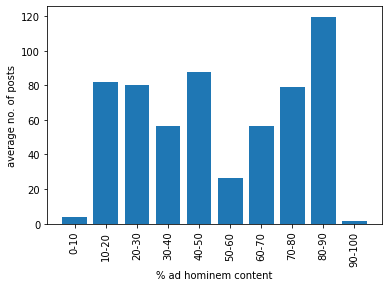

In [ ]:
Plot(x, y, np.average, 'average no. of posts')

## Variation in ad hominem percentage with reward point

In [19]:
reward_points_map = {k : v for k, v in zip(df['username'].tolist(), df['reward_points'].tolist())}

In [20]:
data = dict()  # {author: (reward point, % ad hominem)}

for k, v in user_scores.items():
    try:
        ah_ = get_percentage_ah(v)
        r_ = reward_points_map[k]
        data[k] = (r_, ah_)
    except:
        pass

In [21]:
x, y = get_pairs(data)
print(len(x))

14950


In [22]:
c1 = get_cat1(x, y)
c2 = get_cat2(x, y)
c3 = get_cat3(x, y)
c4 = get_cat4(x, y)
c5 = get_cat5(x, y)

print(f'C1: average={round(np.average(c1), 2)}, std={round(np.std(c1), 2)}')
print(f'C2: average={round(np.average(c2), 2)}, std={round(np.std(c2), 2)}')
print(f'C3: average={round(np.average(c3), 2)}, std={round(np.std(c3), 2)}')
print(f'C4: average={round(np.average(c4), 2)}, std={round(np.std(c4), 2)}')
print(f'C5: average={round(np.average(c5), 2)}, std={round(np.std(c5), 2)}')

_, pval = stats.mannwhitneyu(c1, c5)
print(pval) 

C1: average=6.9, std=14.31
C2: average=169.41, std=1070.35
C3: average=224.95, std=1225.17
C4: average=61.15, std=618.46
C5: average=58.33, std=645.24
0.0011898804888673612


In [ ]:
ux, uy = get_nonzero(x, y)
zx = get_zero(x, y)

In [ ]:
_, pval = stats.mannwhitneyu(ux, zx) 
print(pval)

0.0


In [ ]:
np.std(zx)

14.313370689207071

In [ ]:
print(stats.spearmanr(ux, uy))

SpearmanrResult(correlation=-0.5746734483570959, pvalue=0.0)


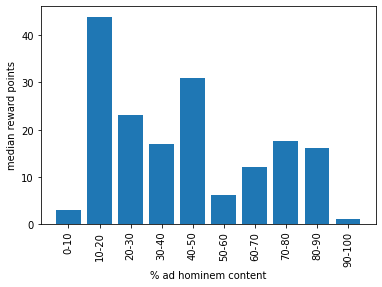

In [ ]:
Plot(x, y, f=np.median, label='median reward points')

## Variation of ad hominem percentage with efficiency of users

In [23]:
efficiency_map = {k : v for k, v in zip(df['username'].tolist(), df['efficiency'].tolist())}

In [24]:
data = dict()  # {author: (efficiency, % ad hominem)}

for k, v in user_scores.items():
    try:
        ah_ = get_percentage_ah(v)
        e_ = efficiency_map[k]
        data[k] = (e_, ah_)
    except:
        pass

In [25]:
x, y = get_pairs(data)

In [26]:
c1 = get_cat1(x, y)
c2 = get_cat2(x, y)
c3 = get_cat3(x, y)
c4 = get_cat4(x, y)
c5 = get_cat5(x, y)

print(f'C1: average={round(np.average(c1), 2)}, std={round(np.std(c1), 2)}')
print(f'C2: average={round(np.average(c2), 2)}, std={round(np.std(c2), 2)}')
print(f'C3: average={round(np.average(c3), 2)}, std={round(np.std(c3), 2)}')
print(f'C4: average={round(np.average(c4), 2)}, std={round(np.std(c4), 2)}')
print(f'C5: average={round(np.average(c5), 2)}, std={round(np.std(c5), 2)}')

_, pval = stats.mannwhitneyu(c1, c5)
print(pval) 

C1: average=91.58, std=13.55
C2: average=88.31, std=13.07
C3: average=88.31, std=11.65
C4: average=90.77, std=13.18
C5: average=88.31, std=15.52
6.653431942121087e-21


In [ ]:
ux, uy = get_nonzero(x, y)
zx = get_zero(x, y)

In [ ]:
_, pval = stats.mannwhitneyu(ux, zx) 
print(pval)

1.8626600083309354e-142


In [ ]:
np.std(zx)

13.545903370308135

In [ ]:
print(stats.spearmanr(ux, uy))

SpearmanrResult(correlation=0.11809499380612896, pvalue=7.066930768431866e-17)


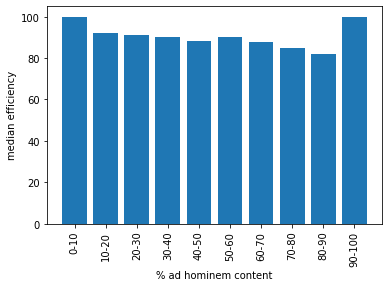

In [ ]:
Plot(x, y, f=np.median, label="median efficiency")

## Variation of ad hominem percentage with different size of groups

In [27]:
allies_map = {k : len(v) for k, v in zip(df['username'].tolist(), df['allies'].tolist())}
enemies_map = {k : len(v) for k, v in zip(df['username'].tolist(), df['enemies'].tolist())}
hostiles_map = {k : len(v) for k, v in zip(df['username'].tolist(), df['hostiles'].tolist())}

In [28]:
data_a = dict()  # {author: (# allies, % ad hominem)}
data_e = dict()  # {author: (# enemies, % ad hominem)}
data_h = dict()  # {author: (# hostiles, % ad hominem)}

for k, v in user_scores.items():
    try:
        ah_ = get_percentage_ah(v)
        a_ = allies_map[k]
        e_ = enemies_map[k]
        h_ = hostiles_map[k]
        data_a[k] = (a_, ah_)
        data_e[k] = (e_, ah_) 
        data_h[k] = (h_, ah_)
    except:
        pass

In [29]:
# allies
x, y = get_pairs(data_a)
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.021786653652515295, 0.007722863636516302)
SpearmanrResult(correlation=0.2028528436046469, pvalue=1.2994606156466126e-138)


In [30]:
c1 = get_cat1(x, y)
c2 = get_cat2(x, y)
c3 = get_cat3(x, y)
c4 = get_cat4(x, y)
c5 = get_cat5(x, y)

print(f'C1: average={round(np.average(c1), 2)}, std={round(np.std(c1), 2)}')
print(f'C2: average={round(np.average(c2), 2)}, std={round(np.std(c2), 2)}')
print(f'C3: average={round(np.average(c3), 2)}, std={round(np.std(c3), 2)}')
print(f'C4: average={round(np.average(c4), 2)}, std={round(np.std(c4), 2)}')
print(f'C5: average={round(np.average(c5), 2)}, std={round(np.std(c5), 2)}')

_, pval = stats.mannwhitneyu(c1, c5)
print(pval) 

C1: average=0.14, std=0.83
C2: average=1.84, std=9.11
C3: average=2.62, std=10.98
C4: average=0.75, std=5.63
C5: average=0.28, std=2.03
0.006310066712300441


In [ ]:
ux, uy = get_nonzero(x, y)
zx = get_zero(x, y)

In [ ]:
_, pval = stats.mannwhitneyu(ux, zx) 
print(pval)

2.761169435948015e-249


In [ ]:
np.std(zx)

0.829412146166433

In [ ]:
print(stats.spearmanr(ux, uy))

SpearmanrResult(correlation=-0.38032816887098064, pvalue=1.5519735704808806e-170)


In [ ]:
Plot(x, y, f=np.median, label="median no. of allies", debug=True)

TypeError: ignored

In [31]:
# for enemies
x, y = get_pairs(data_e)
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.040185980990390745, 8.872713970485291e-07)
SpearmanrResult(correlation=0.21096821164824306, pvalue=5.107622053677832e-150)


In [32]:
c1 = get_cat1(x, y)
c2 = get_cat2(x, y)
c3 = get_cat3(x, y)
c4 = get_cat4(x, y)
c5 = get_cat5(x, y)

print(f'C1: average={round(np.average(c1), 2)}, std={round(np.std(c1), 2)}')
print(f'C2: average={round(np.average(c2), 2)}, std={round(np.std(c2), 2)}')
print(f'C3: average={round(np.average(c3), 2)}, std={round(np.std(c3), 2)}')
print(f'C4: average={round(np.average(c4), 2)}, std={round(np.std(c4), 2)}')
print(f'C5: average={round(np.average(c5), 2)}, std={round(np.std(c5), 2)}')

_, pval = stats.mannwhitneyu(c1, c5)
print(pval) 

C1: average=0.03, std=0.24
C2: average=0.66, std=6.21
C3: average=0.78, std=5.25
C4: average=0.22, std=2.65
C5: average=0.42, std=7.78
1.2812118346809206e-34


In [ ]:
ux, uy = get_nonzero(x, y)
zx = get_zero(x, y)

In [ ]:
_, pval = stats.mannwhitneyu(ux, zx) 
print(pval)

3.674961489387516e-203


In [ ]:
np.std(zx)

0.23508840924328592

In [ ]:
print(stats.spearmanr(ux, uy))

SpearmanrResult(correlation=-0.16565432294251226, pvalue=7.296372315938076e-32)


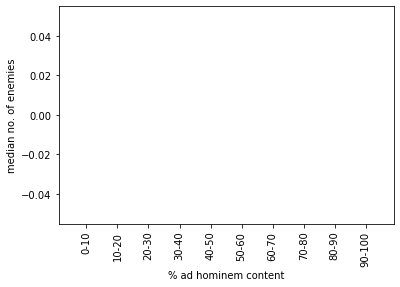

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
Plot(x, y, f=np.median, label="median no. of enemies", debug=True)

In [33]:
# for hostiles
x, y = get_pairs(data_h)
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.07195785396981212, 1.2628362186736782e-18)
SpearmanrResult(correlation=0.2894328237252431, pvalue=2.342345320760956e-286)


In [34]:
c1 = get_cat1(x, y)
c2 = get_cat2(x, y)
c3 = get_cat3(x, y)
c4 = get_cat4(x, y)
c5 = get_cat5(x, y)

print(f'C1: average={round(np.average(c1), 2)}, std={round(np.std(c1), 2)}')
print(f'C2: average={round(np.average(c2), 2)}, std={round(np.std(c2), 2)}')
print(f'C3: average={round(np.average(c3), 2)}, std={round(np.std(c3), 2)}')
print(f'C4: average={round(np.average(c4), 2)}, std={round(np.std(c4), 2)}')
print(f'C5: average={round(np.average(c5), 2)}, std={round(np.std(c5), 2)}')

_, pval = stats.mannwhitneyu(c1, c5)
print(pval) 

C1: average=0.03, std=0.2
C2: average=0.59, std=3.0
C3: average=0.69, std=2.93
C4: average=0.19, std=1.5
C5: average=0.39, std=3.12
7.682544131619302e-147


In [ ]:
ux, uy = get_nonzero(x, y)
zx = get_zero(x, y)

In [ ]:
_, pval = stats.mannwhitneyu(ux, zx) 
print(pval)

0.0


In [ ]:
np.std(zx)

0.1970473304799169

In [ ]:
print(stats.spearmanr(ux, uy))

SpearmanrResult(correlation=-0.12526145793891247, pvalue=8.27302651097694e-19)


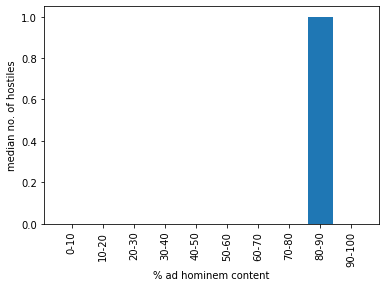

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [ ]:
Plot(x, y, f=np.median, label="median no. of hostiles", debug=True)

# Network Analysis

In [35]:
# loading dataset from drive for interesting topical forums
threads = list()

for cat in tqdm(categories_selected):
    fp = open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/threads.log', 'rb')
    try:
        while True:
            e = pickle.load(fp)
            threads.append(e)
    except EOFError:
        fp.close()

100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


In [36]:
# main function implemented in Notebook - 29

def get_reciprocity_and_users(threads, lambda_, rho_):
    """
    Computes the reciprocity of the support and dispute networks constructed
    using the given threshold.
    """

    # Filter users using (lambda1, lambda2)
    athr = dict()   # {author: level-1 comment count}
    for e in threads:
        if 'root' in e.metaL.keys():
            for key in e.metaL['root'].keys():
                cmnt = e.comments[key]
                cur_athr = cmnt.author
                try:
                    athr[cur_athr] += 1
                except:
                    athr[cur_athr] = 1
        if 'root' in e.metaR.keys():
            for key in e.metaR['root'].keys():
                cmnt = e.comments[key]
                cur_athr = cmnt.author
                try:
                    athr[cur_athr] += 1
                except:
                    athr[cur_athr] = 1
    L1_athr = dict()  # will contains the users that satisfy the level-1 contraints
    for x in athr:
        if athr[x] >= lambda_:
            L1_athr[x] = True

    # Filter users using (rho1, rho2)
    athr = dict()   # reset, and now {author: no. of direct replies}
    def dfs(Map, cmntMap, athr, cid='root'):
        if cid == 'root':
            for key in Map[cid].keys():
                dfs(Map[cid], cmntMap, athr, key)
            return
        cur_author = cmntMap[cid].author

        try:
            athr[cur_author] += len(Map[cid].keys())
        except:
            athr[cur_author] = len(Map[cid].keys())

        for key in Map[cid].keys():
            dfs(Map[cid], cmntMap, athr, key)
            
    for e in threads:
        if 'root' in e.metaL.keys():
            dfs(e.metaL, e.comments, athr)
        if 'root' in e.metaR.keys():
            dfs(e.metaR, e.comments, athr) 
    
    A = []
    for x in athr:
        if athr[x] > rho_:
            try:
                z = L1_athr[x]
                A.append(x)
            except KeyError:
                pass
    
    author_map = dict()
    reverse_map = [""] * len(A)
    author_count = len(A)

    for i in range(author_count):
        author_map[A[i]] = i
        reverse_map[i] = A[i]

    support_matrix = [[0 for j in range(author_count)] for i in range(author_count)]
    dispute_matrix = [[0 for j in range(author_count)] for i in range(author_count)]

    def dfs1(Map, cmntMap, cid='root'):
        if cid == 'root':
            for key in Map[cid].keys():
                dfs1(Map[cid], cmntMap, key)
            return

        cur_author = cmntMap[cid].author
        cur_pol = cmntMap[cid].polarity
        
        if cur_author in author_map and cur_pol != 'Not Available':
            cur_author_id = author_map[cur_author]
            for key in Map[cid].keys():
                nxt_author = cmntMap[key].author
                nxt_pol = cmntMap[key].polarity
                if nxt_author in author_map and nxt_pol != 'Not Available':
                    nxt_author_id = author_map[nxt_author]
                    if cur_pol == nxt_pol:
                        support_matrix[nxt_author_id][cur_author_id] += 1
                    else:
                        dispute_matrix[nxt_author_id][cur_author_id] += 1

        for key in Map[cid].keys():
            dfs1(Map[cid], cmntMap, key)

    for e in threads:
        if 'root' in e.metaL:
            dfs1(e.metaL, e.comments)
        if 'root' in e.metaR:
            dfs1(e.metaR, e.comments)

    support_graph = nx.DiGraph()
    for i in range(author_count):
        for j in range(author_count):
            if support_matrix[i][j] != 0:
                support_graph.add_weighted_edges_from([(i, j, support_matrix[i][j])])

    dispute_graph = nx.DiGraph()
    for i in range(author_count):
        for j in range(author_count):
            if dispute_matrix[i][j] != 0:
                dispute_graph.add_weighted_edges_from([(i, j, dispute_matrix[i][j])])

    support_graph_r = None
    dispute_graph_r = None
    try:
        support_graph_r = nx.algorithms.reciprocity(support_graph)
    except:
        pass
    try:
        dispute_graph_r = nx.algorithms.reciprocity(dispute_graph)
    except:
        pass
    return A, support_graph_r, dispute_graph_r

In [37]:
import networkx as nx

In [38]:
thr = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
tqdm_limit = len(thr) ** 2

support_r = dict()
dispute_r = dict()

s_fail = list()
d_fail = list()

with tqdm(total=tqdm_limit, desc='iter') as pbar:
    for lambda_ in thr:
        for rho_ in thr:
            users, sr, dr = get_reciprocity_and_users(threads, lambda_, rho_)
            if sr is not None:
                for user in users:
                    support_r[user] = sr
            else:
                s_fail.append((lambda_, rho_))
            if dr is not None:
                for user in users:
                    dispute_r[user] = dr
            else:
                d_fail.append((lambda_, rho_))
            pbar.update(1)

iter: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


In [39]:
data_s = dict()
data_d = dict()

for k, v in support_r.items():
    sc = user_scores[k]
    ah_ = get_percentage_ah(sc)
    data_s[k] = (v, ah_)

In [40]:
for k, v in dispute_r.items():
    sc = user_scores[k]
    ah_ = get_percentage_ah(sc)
    data_d[k] = (v, ah_)

In [41]:
x, y = get_pairs(data_s)
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.17925478342032486, 2.3378681954766042e-31)
SpearmanrResult(correlation=0.3495061127321695, pvalue=9.988005376634831e-120)


In [42]:
c1 = get_cat1(x, y)
c2 = get_cat2(x, y)
c3 = get_cat3(x, y)
c4 = get_cat4(x, y)
c5 = get_cat5(x, y)

print(f'C1: average={round(np.average(c1), 2)}, std={round(np.std(c1), 2)}')
print(f'C2: average={round(np.average(c2), 2)}, std={round(np.std(c2), 2)}')
print(f'C3: average={round(np.average(c3), 2)}, std={round(np.std(c3), 2)}')
print(f'C4: average={round(np.average(c4), 2)}, std={round(np.std(c4), 2)}')
print(f'C5: average={round(np.average(c5), 2)}, std={round(np.std(c5), 2)}')

_, pval = stats.mannwhitneyu(c1, c5)
print(pval) 

C1: average=0.58, std=0.02
C2: average=0.64, std=0.06
C3: average=0.64, std=0.06
C4: average=0.62, std=0.06
C5: average=0.62, std=0.06
9.149789698212737e-37


In [ ]:
ux, uy = get_nonzero(x, y)
zx = get_zero(x, y)

In [ ]:
_, pval = stats.mannwhitneyu(ux, zx) 
print(pval)

3.1836200807970146e-264


In [ ]:
np.std(zx)

0.023520126622375313

In [ ]:
print(stats.spearmanr(ux, uy))

SpearmanrResult(correlation=-0.29281263265458435, pvalue=3.857640356450327e-52)


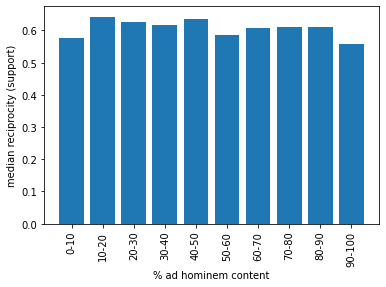

In [ ]:
Plot(x, y, np.median, "median reciprocity (support)")

In [43]:
x, y = get_pairs(data_d)
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.18969823172460806, 5.565379263450218e-35)
SpearmanrResult(correlation=0.35103714714279755, pvalue=7.844122809699007e-121)


In [44]:
c1 = get_cat1(x, y)
c2 = get_cat2(x, y)
c3 = get_cat3(x, y)
c4 = get_cat4(x, y)
c5 = get_cat5(x, y)

print(f'C1: average={round(np.average(c1), 2)}, std={round(np.std(c1), 2)}')
print(f'C2: average={round(np.average(c2), 2)}, std={round(np.std(c2), 2)}')
print(f'C3: average={round(np.average(c3), 2)}, std={round(np.std(c3), 2)}')
print(f'C4: average={round(np.average(c4), 2)}, std={round(np.std(c4), 2)}')
print(f'C5: average={round(np.average(c5), 2)}, std={round(np.std(c5), 2)}')

_, pval = stats.mannwhitneyu(c1, c5)
print(pval) 

C1: average=0.64, std=0.03
C2: average=0.69, std=0.05
C3: average=0.7, std=0.05
C4: average=0.67, std=0.05
C5: average=0.68, std=0.06
3.1288831162670965e-37


In [ ]:
ux, uy = get_nonzero(x, y)
zx = get_zero(x, y)

In [ ]:
_, pval = stats.mannwhitneyu(ux, zx) 
print(pval)

1.215589395115492e-263


In [ ]:
np.std(zx)

0.025538537968833284

In [ ]:
print(stats.spearmanr(ux, uy))

SpearmanrResult(correlation=-0.2864688474323938, pvalue=6.912157427824518e-50)
